# Introduction

A minesweeper environment have been created. In this notebook, the objectif is to try to predict the probabilities of having a bombs in a given cells. To do so, we will create a dataset and try to train a supervised model.

# Presentation of the Environment

The environment has been created in a separate file (few games will be uploaded on github, including this one). It uses the same naming as Gym's env. Let's have a look at the return

In [1]:
from minesweeper.minesweeper import Game as MineSweeper

We can create multiple setups and run the Environment

In [2]:
easy = {"width":8, "height":8, "num_mines":10}
medium = {"width":16, "height":16, "num_mines":40}
hard = {"width":16, "height":30, "num_mines":99}
env = MineSweeper(**easy, seed = None)

In [3]:
env.render()

[[-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]]


The grid is :
    
- -1 when the cell is hidden
- 0..8 when the cell is visible with the value of adjacents bombs
- -100 when we click on a bomb - the game is over

To interact with the environment, we have a method:
- "sample" to return a random position <b>not visible</b>
- "render" to visualize the grid
- "step" taking (row, col) as argument to click on the given cell

In [4]:
env.reset()
r, c = env.sample()
obs, reward, done, info = env.step(r, c)
print("Observation:\n{}\nReward:\t{}\nDone:\t{}\nInfo:\t{}".format(obs, reward, done, info))

Observation:
[[-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1  1  1  1 -1 -1]
 [ 1  1  1  0  0  0  1 -1]
 [ 0  0  0  0  0  0  1 -1]
 [ 2  2  1  0  0  0  2 -1]
 [-1 -1 -1  2  1  2 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]]
Reward:	1
Done:	False
Info:	{'safe_squares': 54, 'exposed_squares': 27, 'num_moves': 1}


In [5]:
r, c = env.sample()
obs, reward, done, info = env.step(r, c)
print("Observation:\n{}\nReward:\t{}\nDone:\t{}\nInfo:\t{}".format(obs, reward, done, info))

Observation:
[[  -1   -1   -1   -1   -1   -1   -1   -1]
 [  -1   -1   -1    1    1    1   -1   -1]
 [   1    1    1    0    0    0    1   -1]
 [   0    0    0    0    0    0    1   -1]
 [   2    2    1    0    0    0    2   -1]
 [  -1   -1   -1    2    1    2   -1   -1]
 [  -1   -1   -1   -1 -100   -1   -1   -1]
 [  -1   -1   -1   -1   -1   -1   -1   -1]]
Reward:	-10
Done:	True
Info:	{'safe_squares': 54, 'exposed_squares': 27, 'num_moves': 2}


# Create Dataset

For this first model, the objectif is to extract all borders positions, take a square of 5x5 around the given position as input. For the output, we use as label the fact that there is a bomb of not.

To simplify the work, we will use a "hard" environement allowing more bombs/configurations possible and we will use only the first move as we are sure to not click on a  bomb (bombs position are generated after first click)

During the extraction, we will need 2 functions:
<ul>
    <li>One to convert the grid to a One-Hot encoded matrix :
        <ul>
            <li>Layer 0 : Contain True if out of the grid</li>
            <li>Layer 1 : Contain True if hidden cell</li>
            <li>Layer 2..11 : Contain True if visible with a given value</li>
        </ul>
    </li>
    <li>One to extract border position which are non visible cells with a positive value around it</li>
</ul>

In [6]:
import numpy as np
from scipy import signal
import gc

def preprocess(grid):
    """
    This function convert the grid to a one-hot encoded matrix of 11 layers
    """
    h, w = grid.shape
    X = np.zeros((h, w, 11), dtype=np.bool)
    for i in range(-2, 9, 1):
        X[:, :, i+2] = (grid == i)
    return X

def cells_to_extract(grid):
    """
    This function return all borders positions 
    """
    filter_ = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]], dtype=np.uint8)
    conv_sum = signal.convolve2d(grid, filter_, mode='same', boundary="fill", fillvalue=-1)
    return np.logical_and((grid == -1), (conv_sum > -8))

Now we can create our dataset. Let's restrict the dataset to "only" 200.000 samples

In [7]:
num_samples = 200000
i = 0
X = np.empty((num_samples, 5, 5, 11), dtype=np.bool)
y = np.empty(num_samples, dtype=np.bool)

env = MineSweeper(**hard, seed = 0)
while i < num_samples:
    env.reset()
    r, c = env.sample()
    obs, reward, done, info = env.step(*env.sample())
    ph = -2*np.ones((obs.shape[0]+4, obs.shape[1]+4))
    ph[2:-2, 2:-2] = obs
    new_obs = preprocess(ph)
    pos = cells_to_extract(ph)
    for row_, col_ in np.argwhere(pos):
        X[i] = new_obs[row_-2:row_+3, col_-2:col_+3]
        y[i] = env.bombs[row_-2, col_-2]
        i += 1
        if i == num_samples:
            break
    print("{}/{}\t".format(i, num_samples), end="\r")

Now we have our dataset, let's check the balance by counting sample with and without bombs. If it's really unbalanced, we will have to adjust it.

In [8]:
np.bincount(y)

array([127230,  72770], dtype=int64)

We don't have a perfect balance but still fine

# Model

The model will be quite simple. We have as input our binary tensor of shape 5x5x11. If will pass through 2 layer of convolution with padding "valid" to have a vector at the end. This will after classified using fully connected layer and a sigmoid to predict the probability of bombs

First let's create a batch generator for train/test sets

In [9]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

def batch_generator(X, y, batch_size=100):
    if batch_size is None:
        while True:
            yield X, y
    else:
        n = X.shape[0]
        b = batch_size
        while True:
            idx = np.random.randint(n, size=b)
            yield X[idx], y[idx]

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now we can create a simple model as explained previously

In [10]:
class Model:
    def __init__(self):
        self.input = tf.placeholder(tf.bool, shape=(None, 5, 5, 11))
        self.x = tf.cast(self.input, tf.float32)
        self.c1 = tf.layers.conv2d(self.x, filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid")
        self.c2 = tf.layers.conv2d(self.c1, filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid")
        self.flat = tf.layers.flatten(self.c2)
        self.d1 = tf.layers.dense(self.flat, units=64, activation=tf.nn.relu)
        self.d2 = tf.layers.dense(self.d1, units=64, activation=tf.nn.relu)
        self.y_pred = tf.layers.dense(self.d2, units=2, activation=None)
        self.probs = tf.nn.softmax(self.y_pred)
        
        self.y_true = tf.placeholder(tf.bool, shape=(None))
        self.y_true2 = tf.cast(self.y_true, tf.uint8)
        self.target = tf.one_hot(self.y_true2, depth=2, axis=1)
        
        self.Xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.target, logits = self.y_pred)
        
        self.optimizer = tf.train.AdamOptimizer(0.01)
        self.train_ops = self.optimizer.minimize(self.Xentropy)
        
        self.pred_label = tf.argmax(self.probs, axis=1)
        
        self.loss = tf.reduce_mean(self.Xentropy)
        self.acc = tf.metrics.accuracy(self.y_true2, self.pred_label)
        
        self.init_g = tf.global_variables_initializer()
        self.init_l = tf.local_variables_initializer()
        gc.collect()

### Training 1 

The first training will be done on a dataset we prepared previously. We will track accuracy and Loss function to compare it with the model 2 we will se later

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

gen_train = batch_generator(X_train, y_train, batch_size=250)
gen_test = batch_generator(X_test, y_test, batch_size=250)

In [12]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

mdl = Model()

config=tf.ConfigProto(device_count={"GPU": 0, "CPU": 1})
history_1 = {"Acc" : [], "Loss":[], "Iter" : [], "Val_Acc" : [], "Val_Loss":[]}
with tf.Session(config=config) as sess:
    mdl.init_g.run()
    mdl.init_l.run()
    for i in range(3000):
        batch_train_X, batch_train_y = next(gen_train)
        batch_test_X, batch_test_y = next(gen_test)
        _, loss_train, acc_train = sess.run([mdl.train_ops, mdl.loss, mdl.acc],
                            feed_dict={
                                mdl.input: batch_train_X,
                                mdl.y_true: batch_train_y
                            })
        loss_test, acc_test = sess.run([mdl.loss, mdl.acc],
                            feed_dict={
                                mdl.input: batch_test_X,
                                mdl.y_true: batch_test_y
                            })
        print("Iter : {} \t Acc : {:.3f}% - Loss : {:.3f}\tVal_Acc : {:.3f}% - Val_Loss : {:.3f}".format(i, acc_train[1]*100, loss_train, acc_test[1]*100, loss_test), end="\r")
        history_1["Iter"].append(i)
        history_1["Acc"].append(acc_train[1])
        history_1["Loss"].append(loss_train)
        history_1["Val_Acc"].append(acc_test[1])
        history_1["Val_Loss"].append(loss_test)

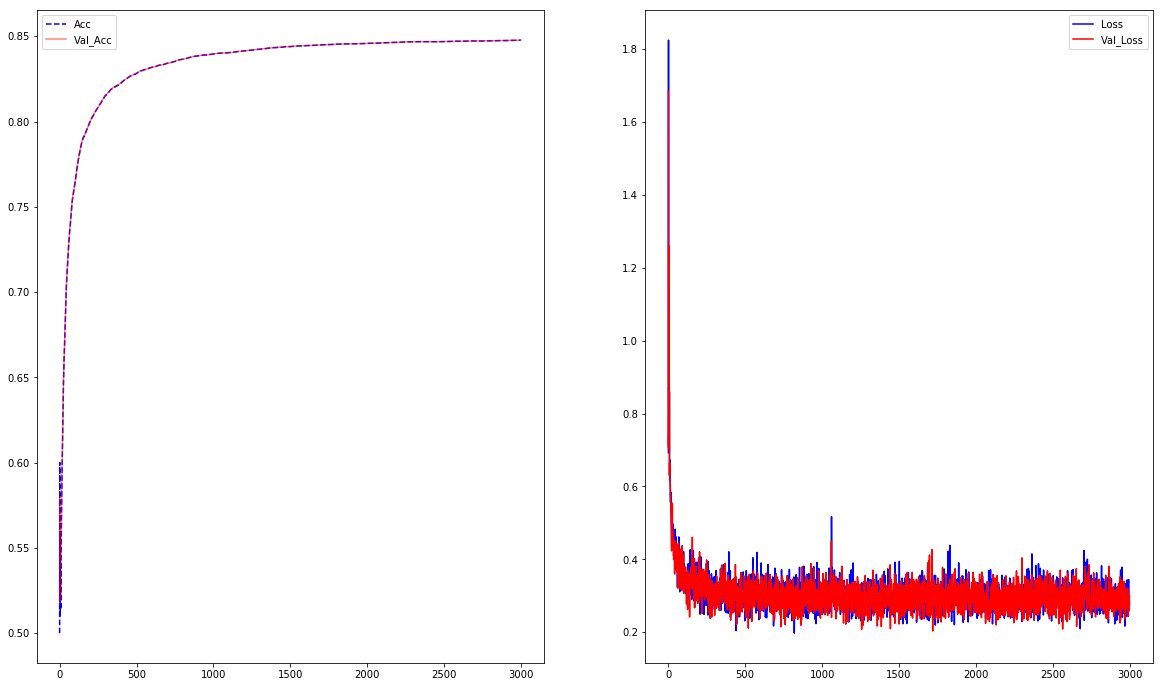

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
ax1.plot(history_1["Iter"], history_1["Acc"], label="Acc", linestyle="--", c="b")
ax1.plot(history_1["Iter"], history_1["Val_Acc"], label="Val_Acc", alpha=0.5, c="r")
ax2.plot(history_1["Iter"], history_1["Loss"], label="Loss", c="b")
ax2.plot(history_1["Iter"], history_1["Val_Loss"], label="Val_Loss", c="r")
ax1.legend()
ax2.legend()
plt.show()

The training result is quite good, we see that it's stable and reaches 85 %. Nevertheless, on a the prevous dataset, we have lot of repeats. As a result, we can have a state in train set also in test set. In the other hand we can also have overfittings. On thing we can do is keep only unique items which will be the next training

### Training 2

Prior to split train/test, we will keep only pairs (input, output) unique items. Our dataset will be a lot smaller but with less risk of "overfitting"

In [14]:
Xflat = X.reshape(-1, 5*5*11)

dataset = np.hstack((Xflat, y.reshape(-1,1)))

In [15]:
_, idx = np.unique(dataset, axis=0, return_index=True)
X = X[idx]
y = y[idx]

del Xflat

Now let's check if our dataset is still balance

In [16]:
np.bincount(y)

array([14872, 10355], dtype=int64)

We can see that the dataset (1/8) is now a lot smaller but have only once every pattern. We can re-train the model using same initial state and seeds to ensure repeatability

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

gen_train = batch_generator(X_train, y_train, batch_size=250)
gen_test = batch_generator(X_test, y_test, batch_size=250)

In [18]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

mdl = Model()

config=tf.ConfigProto(device_count={"GPU": 0, "CPU": 1})
history_2 = {"Acc" : [], "Loss":[], "Iter" : [], "Val_Acc" : [], "Val_Loss":[]}
with tf.Session(config=config) as sess:
    mdl.init_g.run()
    mdl.init_l.run()
    for i in range(3000):
        batch_train_X, batch_train_y = next(gen_train)
        batch_test_X, batch_test_y = next(gen_test)
        _, loss_train, acc_train = sess.run([mdl.train_ops, mdl.loss, mdl.acc],
                            feed_dict={
                                mdl.input: batch_train_X,
                                mdl.y_true: batch_train_y
                            })
        loss_test, acc_test = sess.run([mdl.loss, mdl.acc],
                            feed_dict={
                                mdl.input: batch_test_X,
                                mdl.y_true: batch_test_y
                            })
        print("Iter : {} \t Acc : {:.3f}% - Loss : {:.3f}\tVal_Acc : {:.3f}% - Val_Loss : {:.3f}".format(i, acc_train[1]*100, loss_train, acc_test[1]*100, loss_test), end="\r")
        history_2["Iter"].append(i)
        history_2["Acc"].append(acc_train[1])
        history_2["Loss"].append(loss_train)
        history_2["Val_Acc"].append(acc_test[1])
        history_2["Val_Loss"].append(loss_test)

Except the decrease at the end, we reached 87.5%. It's slightly better but we can't compare it as is. We don't have the exact same dataset. The good point is that generatization is great because test set is only with patterns never saw during training. As a result we have a good model.

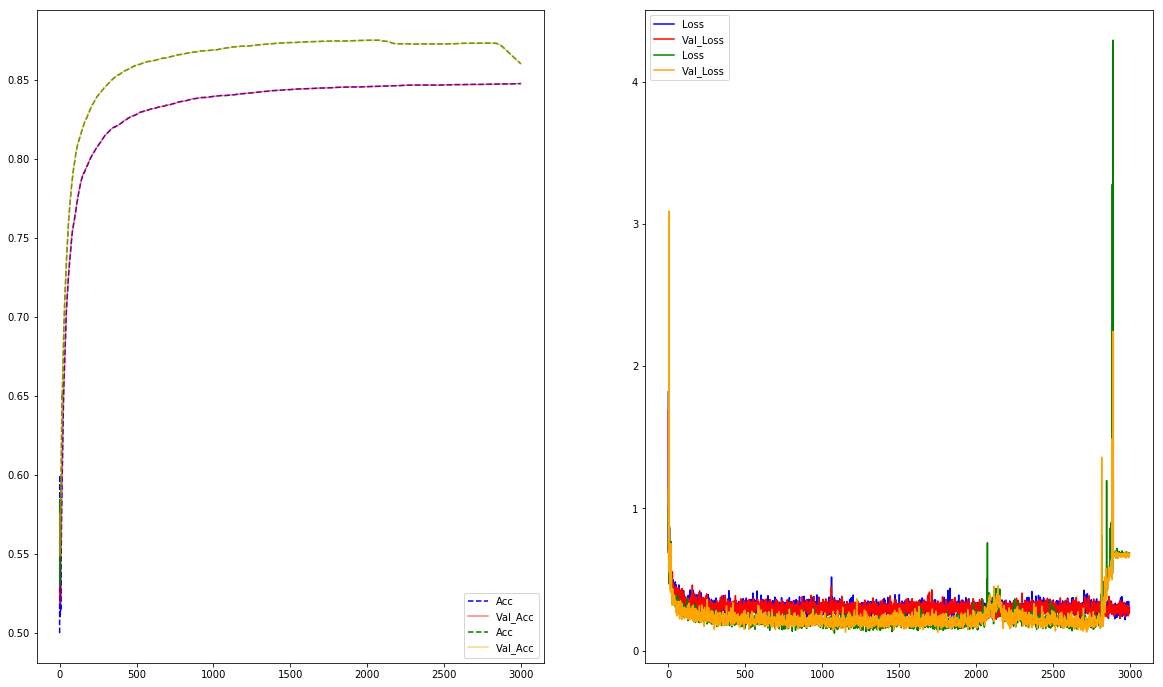

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
ax1.plot(history_1["Iter"], history_1["Acc"], label="Acc", linestyle="--", c="b")
ax1.plot(history_1["Iter"], history_1["Val_Acc"], label="Val_Acc", alpha=0.5, c="r")
ax2.plot(history_1["Iter"], history_1["Loss"], label="Loss", c="b")
ax2.plot(history_1["Iter"], history_1["Val_Loss"], label="Val_Loss", c="r")
ax1.plot(history_2["Iter"], history_2["Acc"], label="Acc", linestyle="--", c="g")
ax1.plot(history_2["Iter"], history_2["Val_Acc"], label="Val_Acc", alpha=0.5, c="orange")
ax2.plot(history_2["Iter"], history_2["Loss"], label="Loss", c="g")
ax2.plot(history_2["Iter"], history_2["Val_Loss"], label="Val_Loss", c="orange")
ax1.legend()
ax2.legend()
plt.show()

This result is also visible on the graph above. The loss is lower and the accuracy is better. We can consider taht this model is fine and would be able to create a bot. 

# Conclusion

We created now a model able with good accuracy to predict is a given cell has a bomb based on neighbor cells. We could create a bot with this model. The bot would predict the probability of bombs for every cells and click on the one with the lowest probability. The drawback is performances as we have to run the model N times per iterations. Another approch would be to create probabilities on all cells at the same time and trained using reinforcement Learning. This will be done a futur Notebook.